# Deep_Learning_from_Scratch_1 - part5

#### 딥러닝의 기본적인 내용을 정리하였습니다. 밑바닥부터 시작하는 딥러닝(사이토 고키 지음)을 참고하였습니다. 

## 6. 학습 관련 기술들 
### 6.1 매개변수 갱신
#### - 신경망 학습 = 매개변수의 최적화 문제
#### 6.1.2 확률적 경사 하강법(SGD)
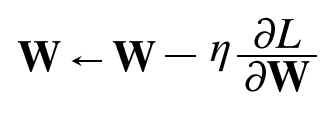

In [2]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

#### 6.1.3 SGD의 단점
#### - SGD의 단점은 비등방성(anisotropy) 함수(= 방향에 따라 성질, 기울기가 달라지는 함수)에서는 탐색 경로가 비효율적이라는 것

#### 6.1.4 모멘텀
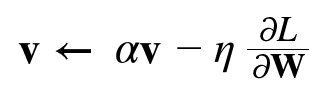
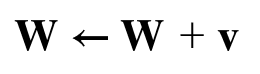

In [3]:
import numpy as np
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lf = lr
        self.momentum = momentum
        self.v = None
    
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
        
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]

#### 6.1.5 AdaGrad
#### - 학습률 감소(learning rate decay) : 학습률을 정하는 효과적 기술, 학습을 진행하면서 학습률을 점차 줄여가는 방법
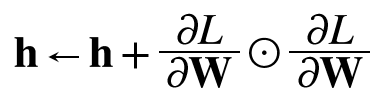
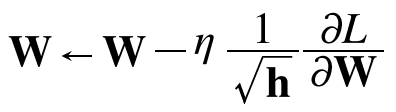

In [5]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
    
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

#### 6.1.6 Adam
#### - Adam = Momentum + AdaGrad
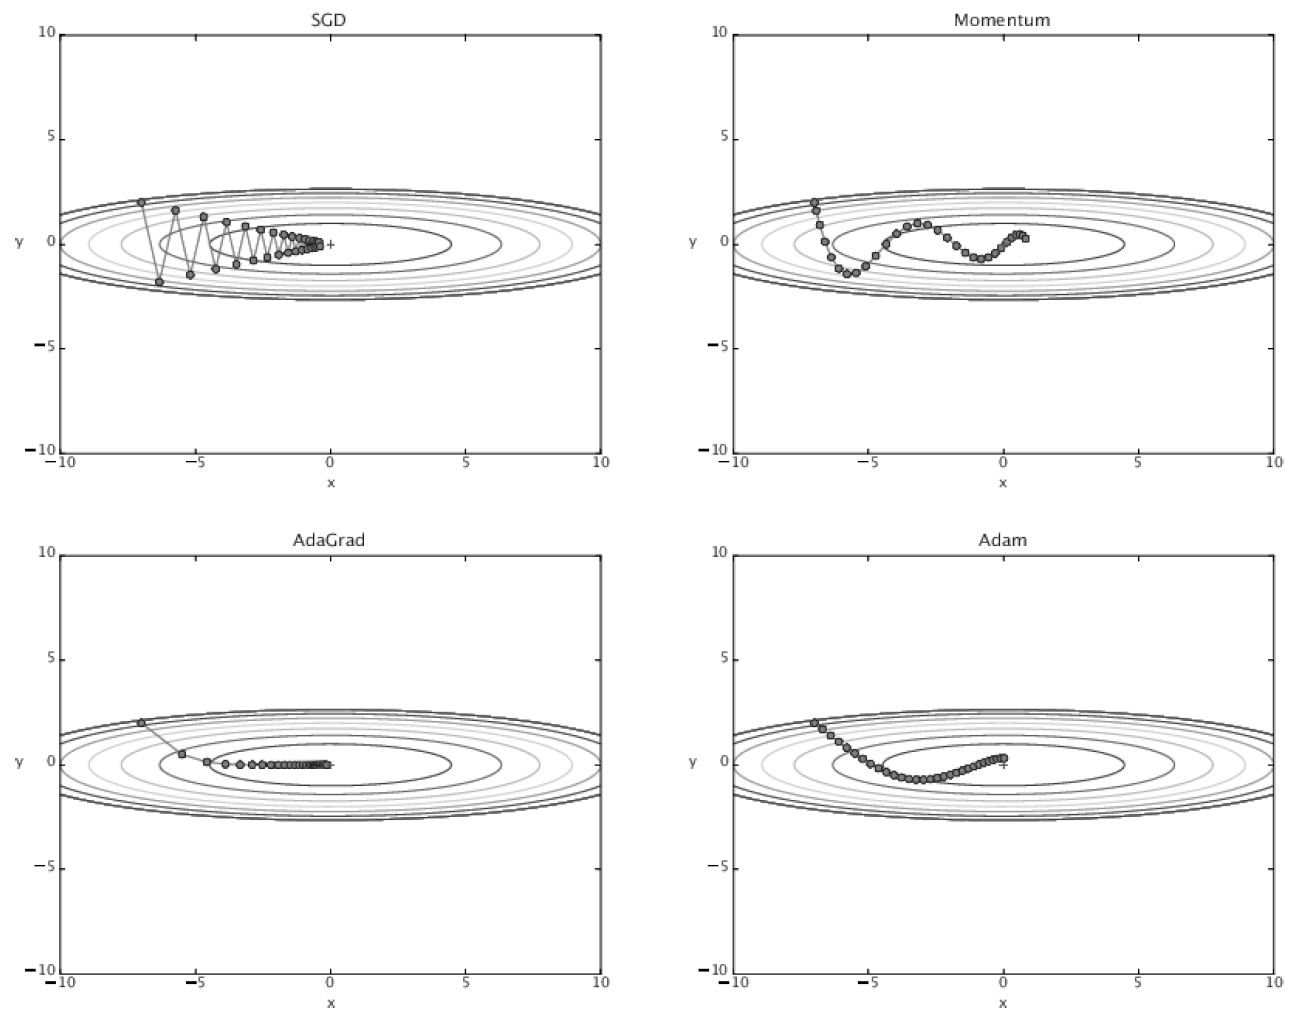

### 6.2 가중치의 초깃값
#### 6.2.1 초깃값을 0으로 하면?
#### - 가중치 감소(weight decay) : 가중치 매개변수의 값이 작아지도록 학습하는 방법, 오버피팅 방지
#### - 가중치가 모두 0일 경우 오차역전법에서 모든 가중치의 값이 똑같이 갱신이 되어서 학습이 제대로 이루어지지 않음

#### 6.2.2 은닉층의 활성화값 분포

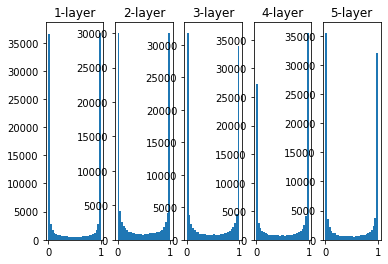

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 100)
node_num = 100
hidden_layer_size = 5
activations = {}

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    
    w = np.random.randn(node_num, node_num) * 1
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z
    
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

#### - Xaiver 초기값
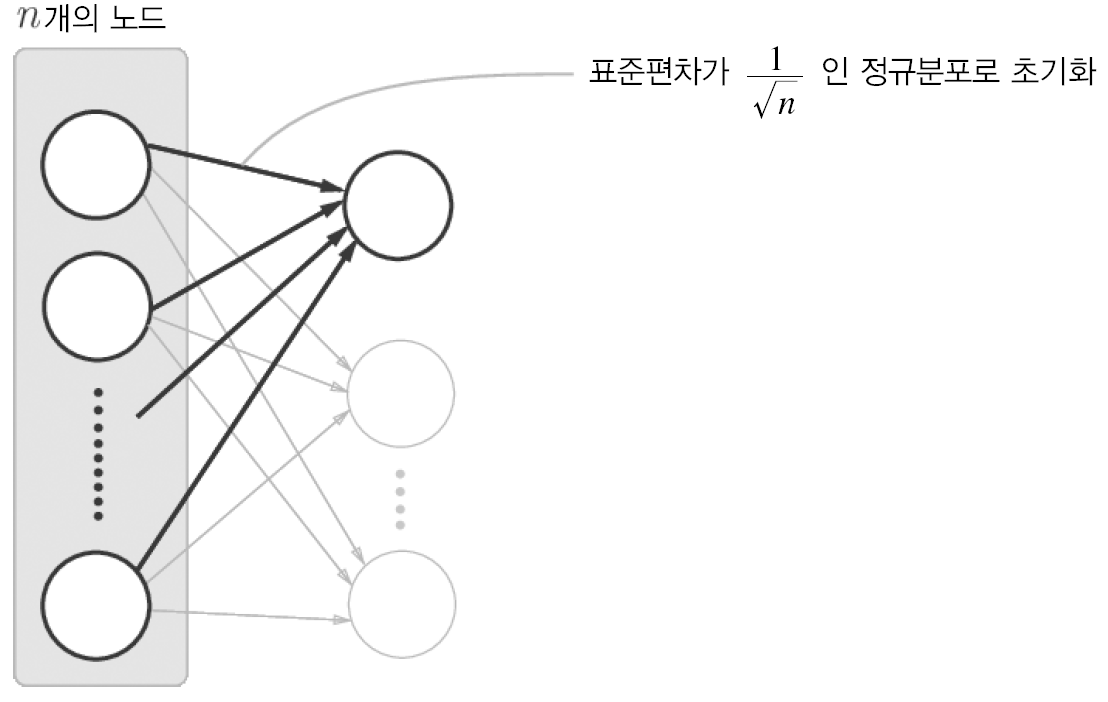

#### 6.2.3 ReLU를 사용할 때의 가중치 초깃값
#### - Xaiver 최값은 활성화 함수가 선형인 것을 전제로 함
#### - sigmoid, tanh함수는 좌우 대칭이라 중앙 부근에서 선형인 함수로 볼 수 있다.
#### - He 초기값 : ReLU에 특화된 초깃값
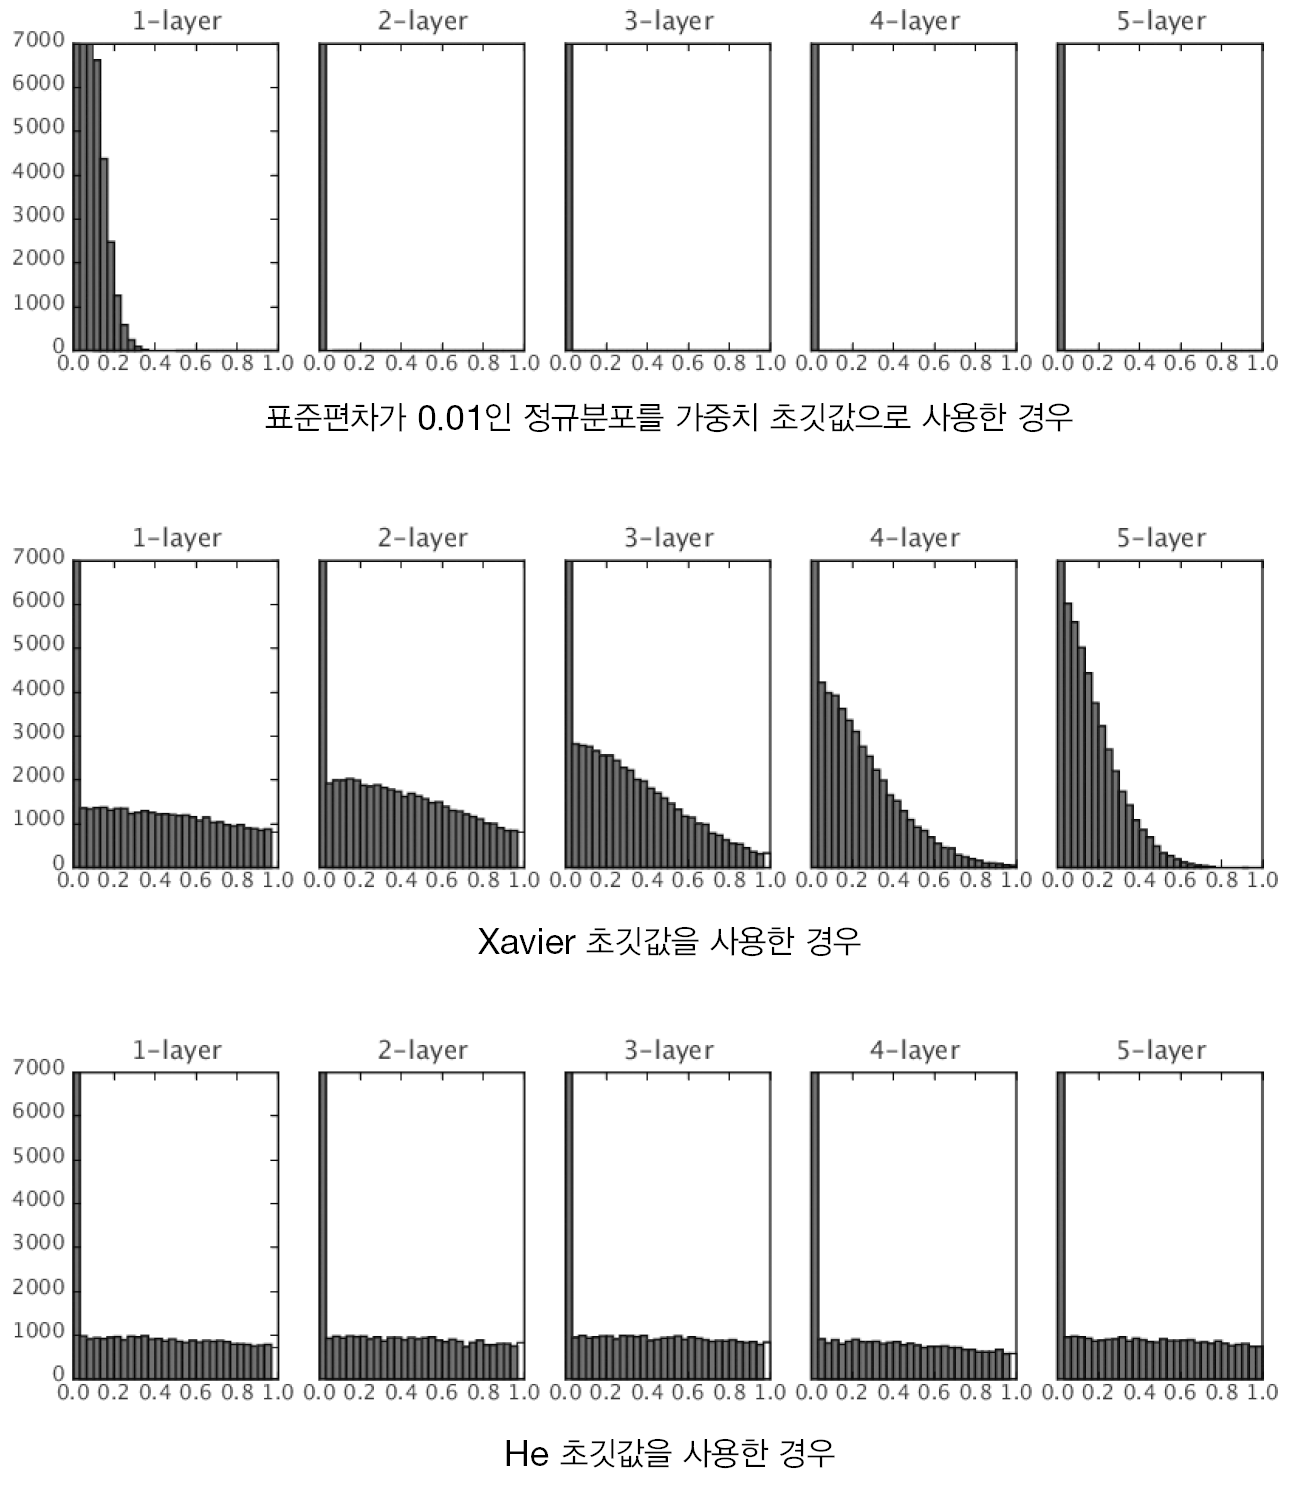

### 6.3 배치 정규화
#### 6.3.1 배치 정규화 알고리즘
#### - 학습속도 개선, 초기값에 크게 의존하지 않음, 오버피팅 억제
#### - 기본 아이디어 : 각 층에서의 활성화값이 적당히 분포되도록 조정
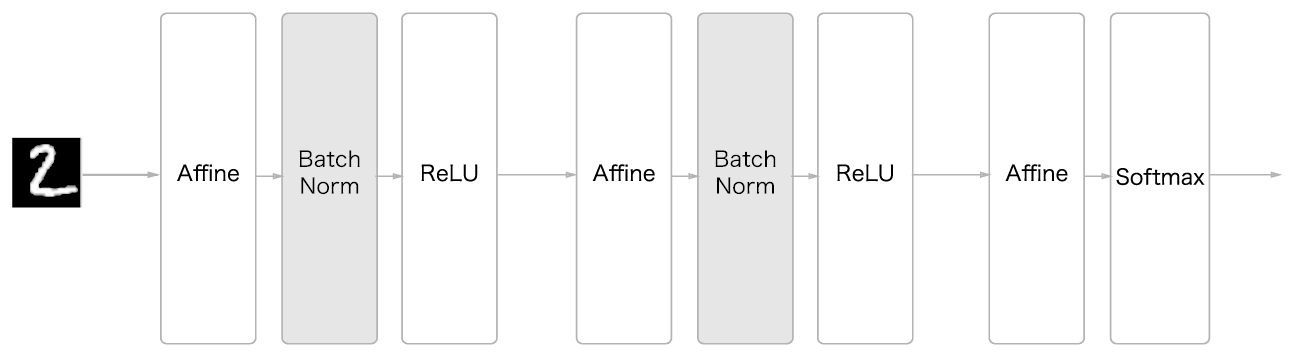
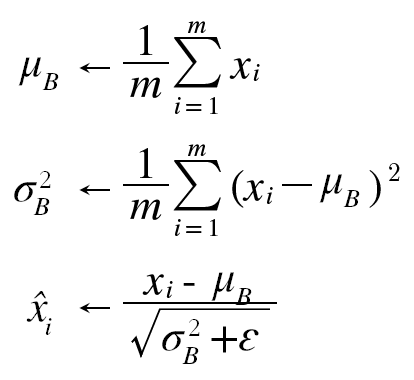
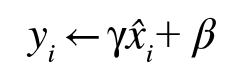
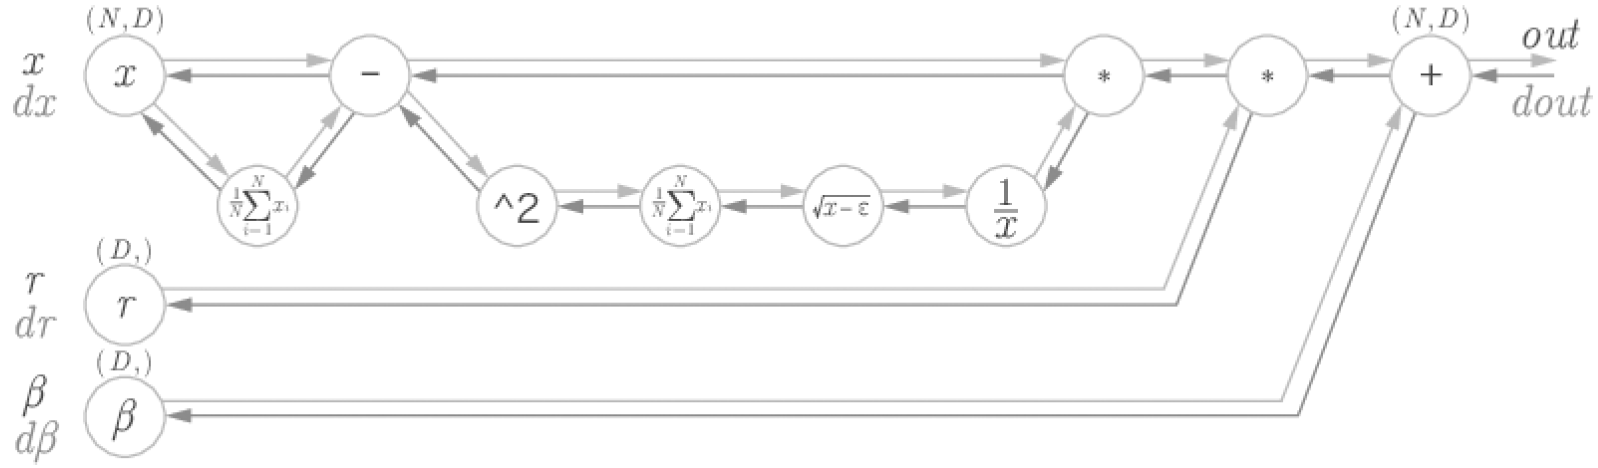

### 6.4 바른 학습을 위해
#### 6.4.1 오버피팅
#### - 매개변수가 많고 표현력이 높은 모델 +  훈련 데이터가 적음
#### 6.4.2 가중치 감소 
#### - 가중치 감소(weight decay) : 학습 과정에서 큰 가중치에 대해서는 그에 상응하는 큰 페널티를 부과하여 오버피팅을 억제, 오버피팅은 가중치 매개변수의 값이 커서 발생하는 경우가 많이 때문
#### 6.4.3 드롭아웃
#### - 뉴런을 임의로 삭제하면서 학습, 훈련 때 은닉층의 뉴런을 무작위로 골라 삭제
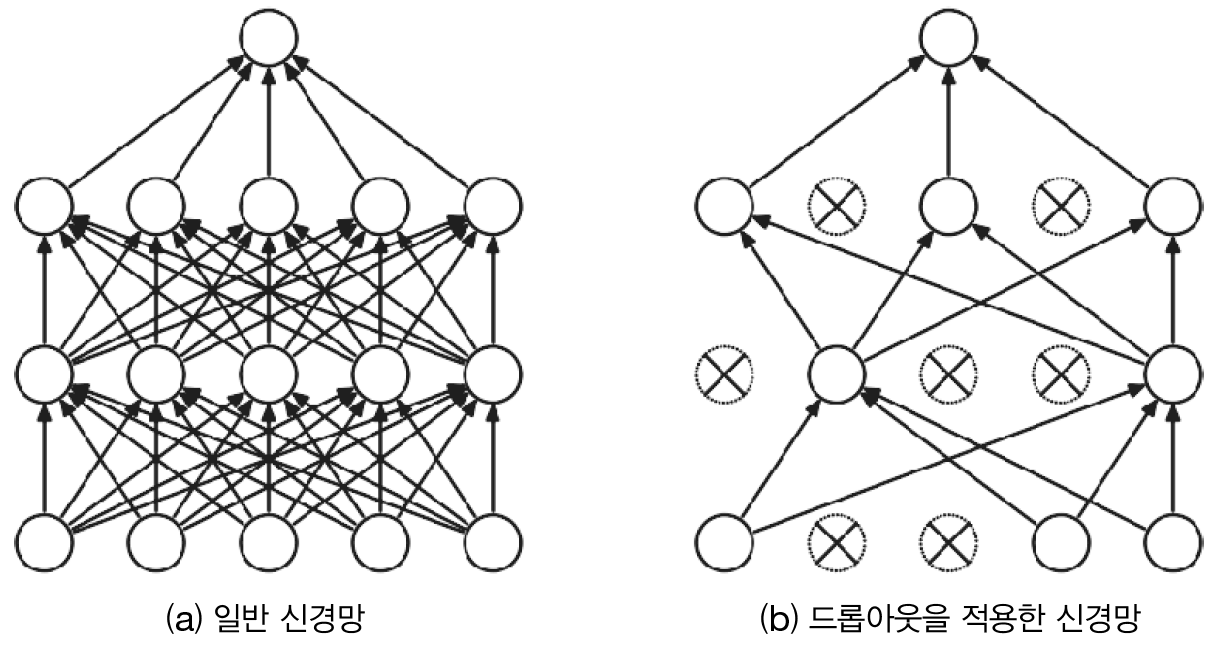

In [10]:
class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None
        
    def forward(self, x, train_flag = True):
        if train_flag:
            self.mask = np.random.rand(**x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)
    
    def backward(self, dout):
        return dout * self.mask

### 6.5 적절한 하이퍼마라미터 값 찾기 
#### 6.5.1 검증 데이터
#### - 하이퍼파라미터 전용 확인 데이터, 하이퍼파라미터의 적절성을 평가
#### - 훈련데이터 : 매개변수 학습 / 검증 데이터 : 하이퍼파라미터 성능 평가 / 시험 데이터 : 신경망의 범용 성능 평가
#### 6.5.2 하이퍼파라미터 최적화
#### - 신경망의 하이퍼파라미터 최적화에서는 그리드 서치같은 규칙적인 탐색보다는 무작위로 샘플링해 탐색하는 편이 좋은 결과를 낸다고 알려져 있다.
#### - 베이즈 최적화 : 베이즈 정리를 중심으로 한 최적화 수행